In [2]:
import os
import sys
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import soundfile as sf
import copy
from IPython.display import Audio, display
import hydra
from omegaconf import OmegaConf
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add the root directory to the path so we can import modules
# Make sure to run this notebook from the root directory
if '.' not in sys.path:
    sys.path.append('.')

#### Visualize three types of scheduler

Saved log-scale plot
Saved linear-scale plot


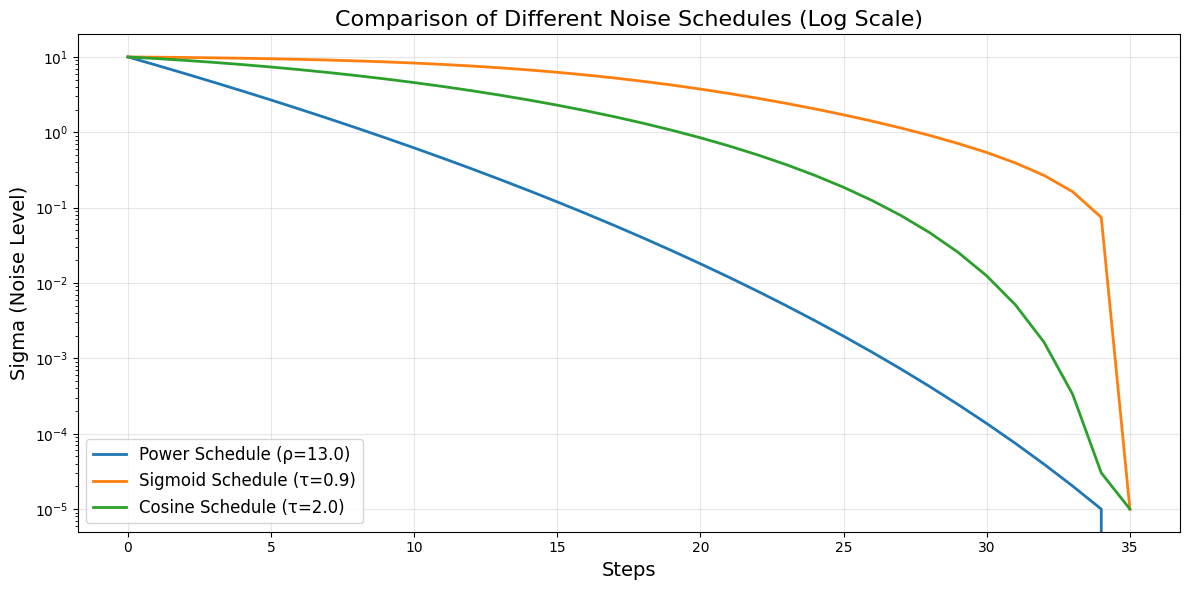

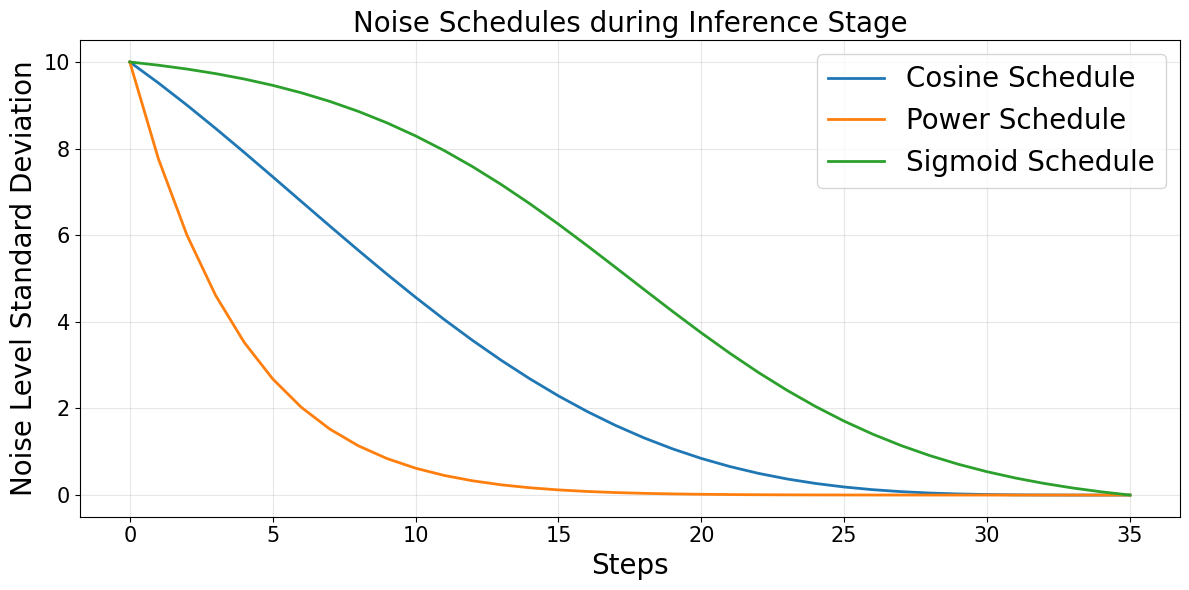

In [4]:


class EDMSchedulePlotter:
    def __init__(self):
        # Parameters from the provided config
        self.sigma_min = 1e-5
        self.sigma_max = 10.0
        self.ro = 13.0
        self.ro_train = 10.0
        # Sigmoid parameters
        self.sigmoid_params = {'start': -3, 'end': 3, 'tau': 0.9}
        # Cosine parameters
        self.cosine_params = {'start': 0.2, 'end': 1.0, 'tau': 2.0}
        # Other parameters
        self.sigma_data = 0.063
        self.P_mean = -1.2
        self.P_std = 1.2
    
    def _sigmoid_schedule(self, t):
        start, end, tau = self.sigmoid_params['start'], self.sigmoid_params['end'], self.sigmoid_params['tau']
        v_start = 1 / (1 + np.exp(-start / tau))
        v_end = 1 / (1 + np.exp(-end / tau))
        output = 1 / (1 + torch.exp(-(t * (end - start) + start) / tau))
        output = (v_end - output) / (v_end - v_start)
        return output

    def _cosine_schedule(self, t):
        start, end, tau = self.cosine_params['start'], self.cosine_params['end'], self.cosine_params['tau']
        v_start = np.cos(start * np.pi / 2) ** (2 * tau)
        v_end = np.cos(end * np.pi / 2) ** (2 * tau)
        output = torch.cos((t * (end - start) + start) * np.pi / 2) ** (2 * tau)
        output = (v_end - output) / (v_end - v_start)
        return output
    
    def create_power_schedule(self, nb_steps):
        i = torch.arange(0, nb_steps+1, dtype=torch.float32)
        t = (self.sigma_max**(1/self.ro) + i/(nb_steps-1) * (self.sigma_min**(1/self.ro) - self.sigma_max**(1/self.ro)))**self.ro
        t[-1] = 0
        return t
    
    def create_sigmoid_schedule(self, nb_steps):
        i = torch.arange(0, nb_steps+1, dtype=torch.float32) / nb_steps
        gamma = self._sigmoid_schedule(i)
        t = self.sigma_min + (self.sigma_max - self.sigma_min) * gamma
        return t
    
    def create_cosine_schedule(self, nb_steps):
        i = torch.arange(0, nb_steps+1, dtype=torch.float32) / nb_steps
        gamma = self._cosine_schedule(i)
        t = self.sigma_min + (self.sigma_max - self.sigma_min) * gamma
        return t
    
    def plot_schedules(self, nb_steps=100):
        power_schedule = self.create_power_schedule(nb_steps)
        sigmoid_schedule = self.create_sigmoid_schedule(nb_steps)
        cosine_schedule = self.create_cosine_schedule(nb_steps)
        
        # Convert to numpy for plotting
        power_np = power_schedule.numpy()
        sigmoid_np = sigmoid_schedule.numpy()
        cosine_np = cosine_schedule.numpy()
        
        # Log scale plot
        plt.figure(figsize=(12, 6))
        steps = np.arange(0, nb_steps+1)
        
        plt.plot(steps, power_np, label=f'Power Schedule (ρ={self.ro})', linewidth=2)
        plt.plot(steps, sigmoid_np, label=f'Sigmoid Schedule (τ={self.sigmoid_params["tau"]})', linewidth=2)
        plt.plot(steps, cosine_np, label=f'Cosine Schedule (τ={self.cosine_params["tau"]})', linewidth=2)
        
        plt.xlabel('Steps', fontsize=14)
        plt.ylabel('Sigma (Noise Level)', fontsize=14)
        plt.title('Comparison of Different Noise Schedules (Log Scale)', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.yscale('log')  # Using log scale to better visualize the differences
        plt.tight_layout()
        plt.savefig('noise_schedule_comparison_log.png', dpi=300)
        print("Saved log-scale plot")
        
        # Linear scale plot
        plt.figure(figsize=(12, 6))
        plt.plot(steps, cosine_np, label=f'Cosine Schedule', linewidth=2)
        plt.plot(steps, power_np, label=f'Power Schedule', linewidth=2)
        plt.plot(steps, sigmoid_np, label=f'Sigmoid Schedule', linewidth=2)
 
        
        plt.xlabel('Steps', fontsize=20)
        plt.ylabel('Noise Level Standard Deviation', fontsize=20)
        plt.title('Noise Schedules during Inference Stage', fontsize=20)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)
        plt.legend(fontsize=20)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('noise_schedule_comparison_linear.png', format='png')
        print("Saved linear-scale plot")
        
# Create and use the plotter
plotter = EDMSchedulePlotter()
plotter.plot_schedules(35)

#### Load Model Configuration
Use Well Trained model from original paper

Test different noise scheduler

In [3]:
# Load configuration
config_path = "E:\\Class\\ECE661\\Diffusion_Audio_Inpainting\\Config_MusicNet.yaml"
config = OmegaConf.load(config_path)

config.dset.path = 'E:\\Class\\ECE661\\audio-inpainting-diffusion\\musicnet\\train_data'
config.dset.test.path = 'E:\\Class\\ECE661\\audio-inpainting-diffusion\\musicnet\\test_data'

# Update model checkpoint path
checkpoint_path = 'E:\\Class\\ECE661\\Diffusion_Audio_Inpainting\\musicnet_44k_4s-560000.pt'
#checkpoint_path = "E:\Class\ECE661\Diffusion_Audio_Inpainting\maestro_22k_8s-750000.pt"
#checkpoint_path = "E:\\Class\\ECE661\\Diffusion_Audio_Inpainting\\under_threshold-step3D0.0616.ckpt"

config.tester.checkpoint = checkpoint_path

# Set output directory for results
output_dir = 'noise_scheduler_experiments_inference_musicnet'
os.makedirs(output_dir, exist_ok=True)

#### Load Helper Functions of Audio playing and visualization

In [4]:
# Import and set up key modules
import utils.dnnlib as dnnlib
import utils.logging as utils_logging
import utils.training_utils as t_utils

# Helper function to plot audio waveform
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.cpu().numpy()
    if len(waveform.shape) > 1 and waveform.shape[0] == 1:
        waveform = waveform[0]  # Remove batch dimension
    
    num_samples = waveform.shape[-1]
    time_axis = np.linspace(0, num_samples / sr, num_samples)
    
    plt.figure(figsize=(6, 4))
    plt.plot(time_axis, waveform)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Helper function to play audio
def play_audio(waveform, sr):
    waveform = waveform.cpu().numpy()
    if len(waveform.shape) > 1 and waveform.shape[0] == 1:
        waveform = waveform[0]  # Remove batch dimension
    
    display(Audio(waveform, rate=sr))

#### Set up the Network and Diffusion Scheduler

In [13]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create network model
from networks.unet_cqt_oct_with_projattention_adaLN_2 import Unet_CQT_oct_with_attention
network = Unet_CQT_oct_with_attention(config, device)
print("Network setup complete")
network = network.to(device)
network.eval()  # Set to evaluation mode

# Create diffusion parameters
from diff_params.edm import EDM
diff_parameters=EDM(config)
print("Diffusion parameters setup complete")

Using device: cuda
using a kaiser window with beta= 1
Attention layer at (down) octave 5
Attention layer at (down) octave 6
Attention layer at (down) octave 7
Attention layer at (up) oct layer 7
Attention layer at (up) oct layer 6
Attention layer at (up) oct layer 5
Network setup complete
Diffusion parameters setup complete


In [14]:
# Load the model checkpoint for original
torch.serialization.add_safe_globals(config)
checkpoint = torch.load(checkpoint_path, map_location=device)
network.load_state_dict(checkpoint['network'])
print("Model loaded successfully!")

C:\Users\wei nora zhang\AppData\Local\Temp\ipykernel_98824\2787767155.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_locati

Model loaded successfully!


#### Create Inpainting Test Example

In [16]:
import random

# Load a test audio sample
def load_test_audio(path=None,random_file = True):
    if path is None:
        # Load the first file from the test directory
        test_dir = config.dset.test.path
        files = [f for f in os.listdir(test_dir) if f.endswith('.wav')]
        if not files:
            raise ValueError(f"No wav files found in {test_dir}")
        if random_file:
            path = os.path.join(test_dir, files[random.randint(0, len(files) - 1)])
        else:
            path = os.path.join(test_dir, files[0])
    
    waveform, sr = torchaudio.load(path)
    # Ensure consistent shape: mono, and correct length
    if waveform.shape[0] > 1:  # Convert to mono if stereo
        waveform = waveform.mean(dim=0, keepdim=True)
    
    target_length = config.exp.audio_len
    if waveform.shape[1] < target_length:
        # Pad if too short
        padding = torch.zeros(1, target_length - waveform.shape[1])
        waveform = torch.cat([waveform, padding], dim=1)
    elif waveform.shape[1] > target_length:
        max_start = waveform.shape[1] - target_length
        start = random.randint(0, max_start)
        waveform = waveform[:, start:start + target_length]
    
    # Resample if needed
    if sr != config.exp.sample_rate:
        resampler = torchaudio.transforms.Resample(sr, config.exp.sample_rate)
        waveform = resampler(waveform)
    
    return waveform.to(device), config.exp.sample_rate

# Create a mask for inpainting
def create_inpainting_mask(audio_length, gap_length_ms=1500, start_idx=None):
    mask = torch.ones(1, audio_length).to(device)
    gap_length_samples = int(gap_length_ms * config.exp.sample_rate / 1000)
    
    if start_idx is None:
        # Place gap in the middle
        start_idx = (audio_length - gap_length_samples) // 2
    
    mask[:, start_idx:start_idx + gap_length_samples] = 0
    return mask

Load, Play, Visualize a ramdom example

Loaded test audio: shape=torch.Size([1, 184184]), sr=44100


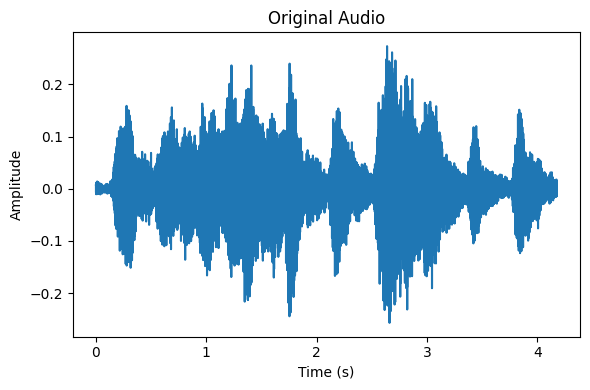

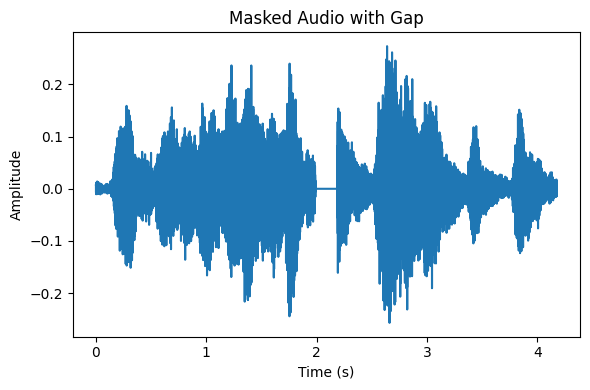

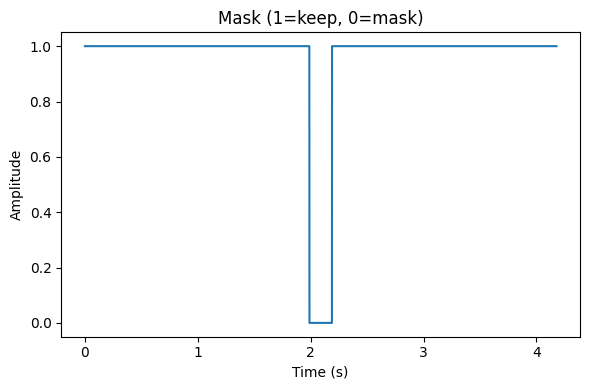

Original Audio:



Masked Audio:


In [17]:
# Load test audio
test_audio, sr = load_test_audio()
print(f"Loaded test audio: shape={test_audio.shape}, sr={sr}")

# Create inpainting mask
gap_length_ms = 200 # 200ms
mask = create_inpainting_mask(test_audio.shape[1], gap_length_ms)

# Apply mask to create masked audio
masked_audio = test_audio * mask

# Visualize
plot_waveform(test_audio, sr, "Original Audio")
plot_waveform(masked_audio, sr, "Masked Audio with Gap")
plot_waveform(mask, sr, "Mask (1=keep, 0=mask)")

# Play original and masked audio
print("Original Audio:")
play_audio(test_audio, sr)
print("\nMasked Audio:")
play_audio(masked_audio, sr)

In [18]:
from utils.training_utils import compute_LSD
lsd_masked=compute_LSD(test_audio, masked_audio, win_size=1024, hop_size=256)
print(f"LSD of masked audio: {lsd_masked}")
lsd_original=compute_LSD(test_audio, test_audio, win_size=1024, hop_size=256)
print(f"LSD of original audio: {lsd_original}")

LSD of masked audio: 0.23687291145324707
LSD of original audio: 0.0


In [19]:
import numpy as np
import matplotlib.pyplot as plt

sample_num = 5
gap_length_ms_list = [50,200,400]
lsd_list = {}

# Collect LSD values
for gap_length_ms in gap_length_ms_list:
    lsd_list[gap_length_ms] = []
    for i in range(sample_num):
        test_audio, sr = load_test_audio()
        mask = create_inpainting_mask(test_audio.shape[-1], gap_length_ms)
        masked_audio = test_audio * mask
        
        lsd_masked = compute_LSD(test_audio, masked_audio, win_size=1024, hop_size=256)
        lsd_masked=lsd_masked.cpu().numpy()
        lsd_list[gap_length_ms].append(lsd_masked)

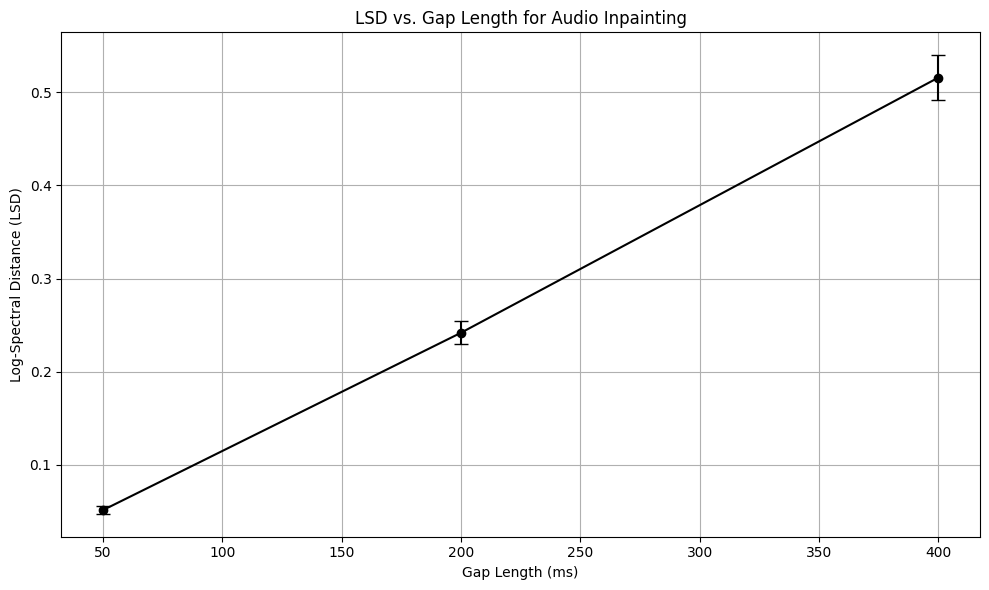

In [20]:
# Compute means and stds
means = [np.mean(lsd_list[gap]) for gap in gap_length_ms_list]
stds = [np.std(lsd_list[gap]) for gap in gap_length_ms_list]

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(gap_length_ms_list, means, yerr=stds, fmt='-o', capsize=5,color='k')
plt.xlabel("Gap Length (ms)")
plt.ylabel("Log-Spectral Distance (LSD)")
plt.title("LSD vs. Gap Length for Audio Inpainting")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Function to Run Inpainting with Different Noise Scheduler Parameters

In [21]:
def resample_audio(audio, sr):
        #this has been reused from the trainer.py
        return t_utils.resample_batch(audio, sr, config.exp.sample_rate, config.exp.audio_len)


def run_inpainting_experiment(audio, mask, diff_params_config):
    """
    Run audio inpainting with specified noise scheduler parameters
    
    Args:
        audio: Input audio tensor with shape [1, length]
        mask: Binary mask tensor with shape [1, length] (1=keep, 0=inpaint)
    
    Returns:
        Inpainted audio tensor
    """
    # Create a copy of the diffusion parameters and update with new config
    dp = copy.deepcopy(diff_parameters)
    
    # Update diffusion parameters
    for key, value in diff_params_config.items():
        setattr(dp, key, value)
    
    # Create a special config for the sampler
    sampler_config = copy.deepcopy(config)
    sampler_config.tester.T = diff_params_config.get('nb_steps', 35)  # Number of sampling steps
    
    # Create the sampler
    sampler = dnnlib.call_func_by_name(
        func_name="testing.edm_sampler_inpainting.Sampler",
        model=network,
        diff_params=dp,
        args=sampler_config,
        rid=False
    )
    
    # Run inpainting
    # Setup mask for sampler
    sampler.mask = mask
    
    # Apply mask to audio
    masked_audio = audio * mask
    
    # Define degradation function (applying mask)
    degradation = lambda x: mask * x

    # Perform inpainting
    inpainted = sampler.predict_inpainting(masked_audio, mask)
    
    return inpainted

#### Experiment with different noise scheduler

In [27]:
def plot_waveform_and_spectrogram(audio, sr, title=""):
    fig, axs = plt.subplots(2, 1, figsize=(10, 4))
    axs[0].plot(audio.cpu().numpy().T[0])
    axs[0].set_title(f'Waveform - {title}')

    
    spec = torchaudio.transforms.MelSpectrogram()(audio.cpu())
    axs[1].imshow(spec.log2()[0,:,:].numpy(), origin='lower', aspect='auto')
    axs[1].set_title(f'Spectrogram - {title}')
    
    plt.tight_layout()
    plt.show()


=== Testing gap length: 100ms ===

Processing sample 1/5
using power schedule


100%|██████████| 35/35 [10:58<00:00, 18.80s/it]


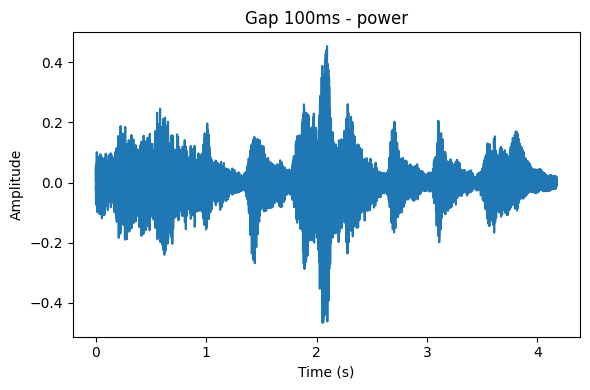


Inpainted Audio (Gap 100ms - power):


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


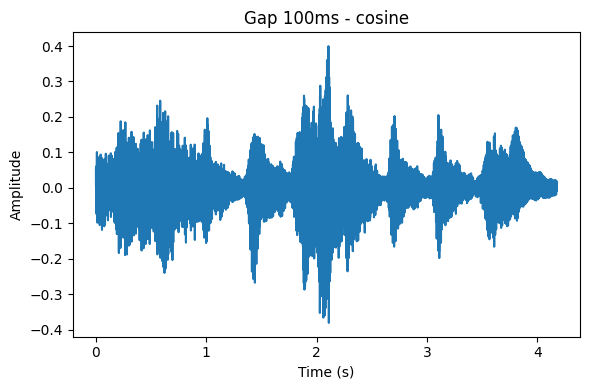


Inpainted Audio (Gap 100ms - cosine):


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


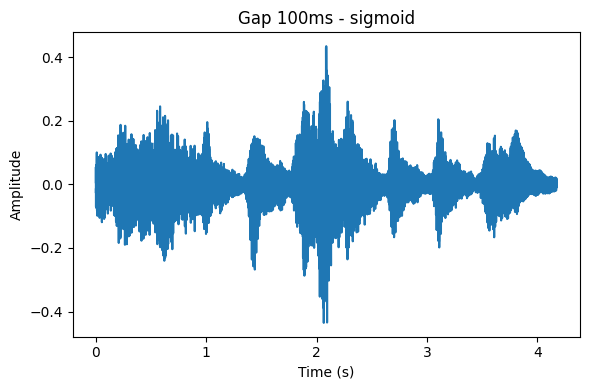


Inpainted Audio (Gap 100ms - sigmoid):



Processing sample 2/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:55<00:00, 18.72s/it]



Processing sample 3/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]



Processing sample 4/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]



Processing sample 5/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]



=== Testing gap length: 200ms ===

Processing sample 1/5
using power schedule


100%|██████████| 35/35 [10:54<00:00, 18.69s/it]


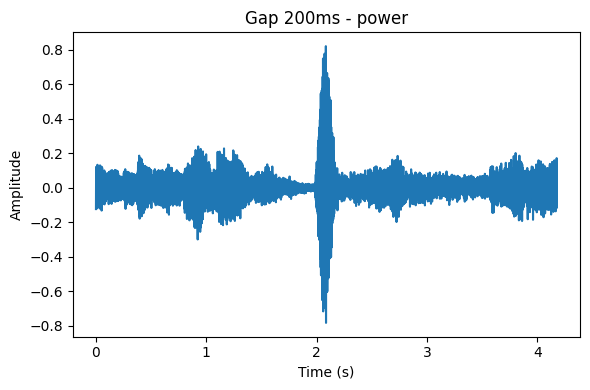


Inpainted Audio (Gap 200ms - power):


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


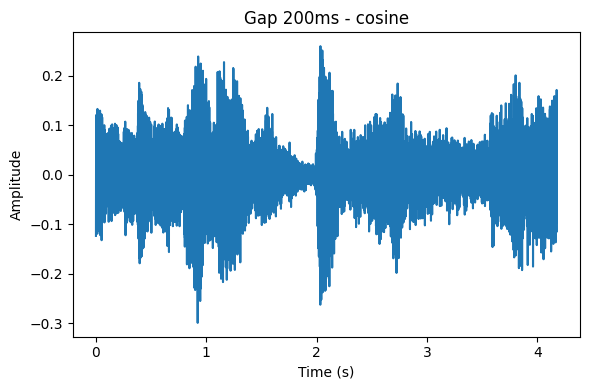


Inpainted Audio (Gap 200ms - cosine):


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


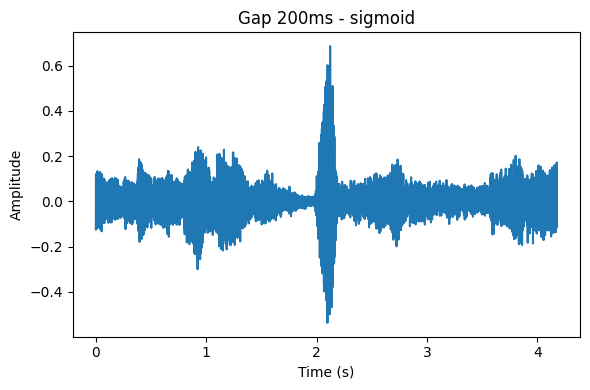


Inpainted Audio (Gap 200ms - sigmoid):



Processing sample 2/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]



Processing sample 3/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]



Processing sample 4/5
using power schedule


100%|██████████| 35/35 [10:54<00:00, 18.71s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]



Processing sample 5/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]



=== Testing gap length: 400ms ===

Processing sample 1/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.67s/it]


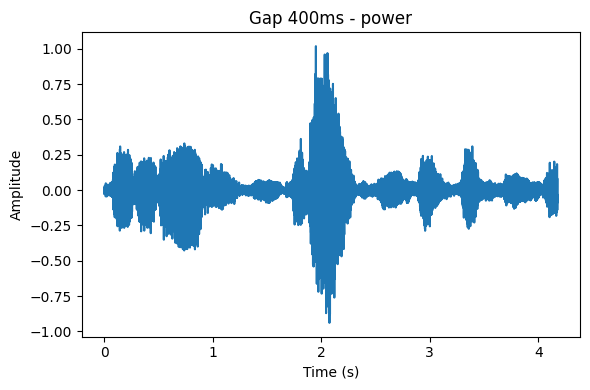


Inpainted Audio (Gap 400ms - power):


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


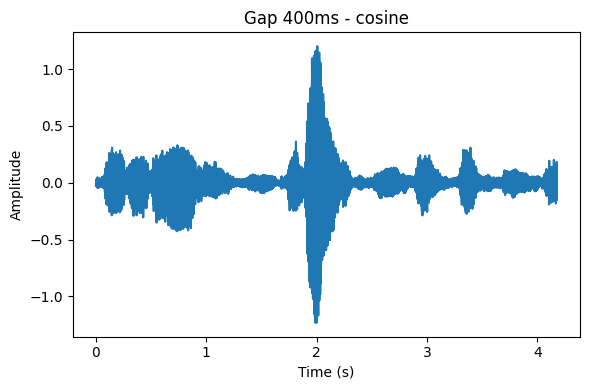


Inpainted Audio (Gap 400ms - cosine):


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


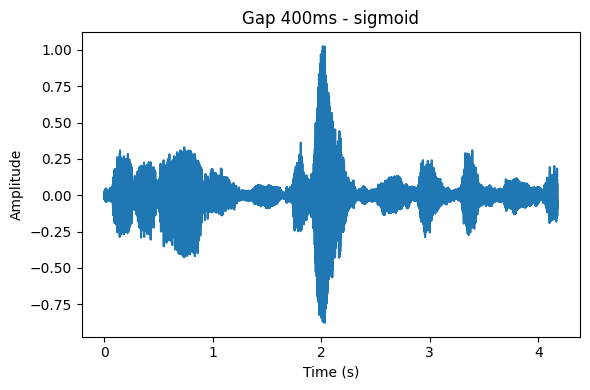


Inpainted Audio (Gap 400ms - sigmoid):



Processing sample 2/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]



Processing sample 3/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using cosine schedule


100%|██████████| 35/35 [10:58<00:00, 18.83s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:55<00:00, 18.72s/it]



Processing sample 4/5
using power schedule


100%|██████████| 35/35 [10:54<00:00, 18.69s/it]


using cosine schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]



Processing sample 5/5
using power schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


using cosine schedule


100%|██████████| 35/35 [10:55<00:00, 18.72s/it]


using sigmoid schedule


100%|██████████| 35/35 [10:53<00:00, 18.68s/it]


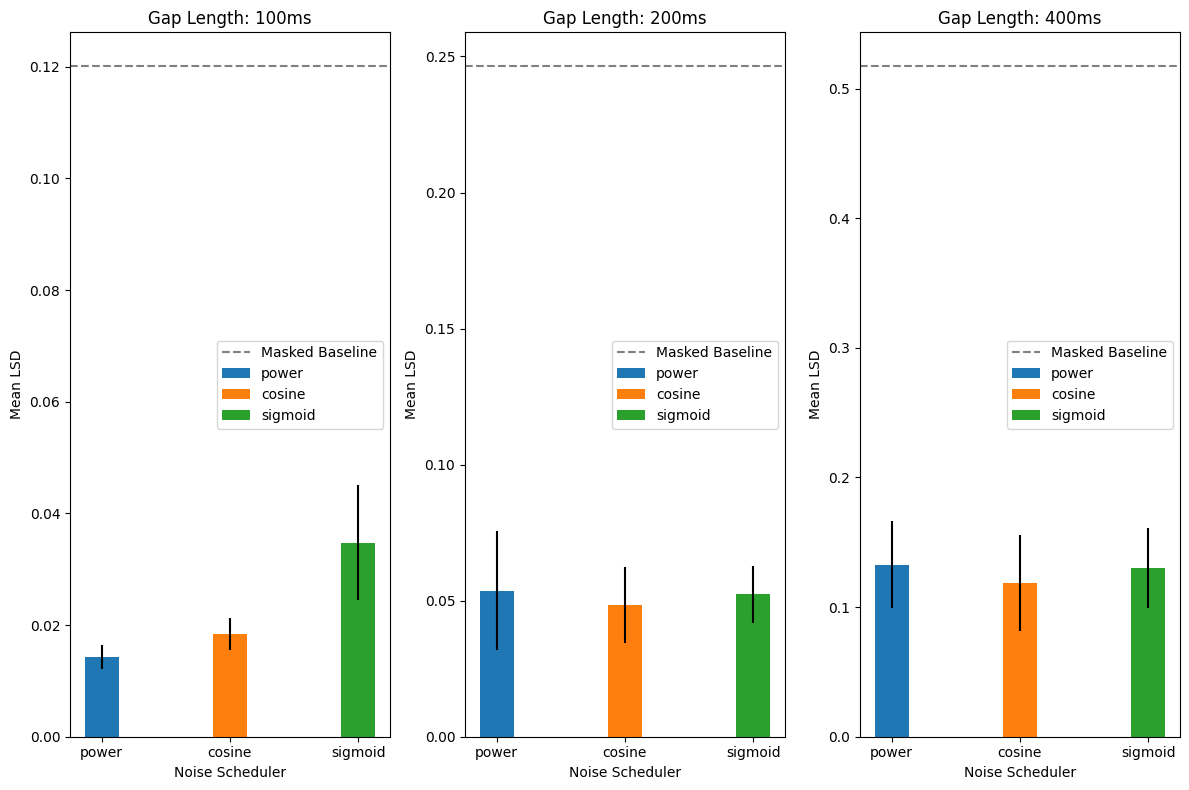


=== Summary Statistics ===

Gap Length: 100ms
  power: Mean LSD = 0.0143 ± 0.0021
  cosine: Mean LSD = 0.0184 ± 0.0028
  sigmoid: Mean LSD = 0.0348 ± 0.0103

Gap Length: 200ms
  power: Mean LSD = 0.0536 ± 0.0219
  cosine: Mean LSD = 0.0483 ± 0.0140
  sigmoid: Mean LSD = 0.0523 ± 0.0104

Gap Length: 400ms
  power: Mean LSD = 0.1328 ± 0.0333
  cosine: Mean LSD = 0.1189 ± 0.0371
  sigmoid: Mean LSD = 0.1298 ± 0.0309


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torchaudio

# Configuration
sample_num = 5
gap_length_ms_list = [100, 200, 400]
noise_scheduler_list = ['power', 'cosine', 'sigmoid']
output_dir = "inpainting_length_scheduler_comparison"
os.makedirs(output_dir, exist_ok=True)

# Results storage
LSD_results = {}
LSD_masked_results = {}

# Initialize results structure
for gap_length_ms in gap_length_ms_list:
    LSD_results[gap_length_ms] = {}
    LSD_masked_results[gap_length_ms] = []
    for noise_scheduler in noise_scheduler_list:
        LSD_results[gap_length_ms][noise_scheduler] = []

# Run experiments
for gap_length_ms in gap_length_ms_list:
    print(f"\n=== Testing gap length: {gap_length_ms}ms ===")
    
    for i in range(sample_num):
        print(f"\nProcessing sample {i+1}/{sample_num}")
        
        # Load test audio and create mask
        test_audio, sr = load_test_audio()
        mask = create_inpainting_mask(test_audio.shape[-1], gap_length_ms)
        masked_audio = test_audio * mask
        
        # Calculate baseline LSD for masked audio
        lsd_masked = compute_LSD(test_audio, masked_audio, win_size=1024, hop_size=256)
        lsd_masked = lsd_masked.cpu().numpy()
        LSD_masked_results[gap_length_ms].append(lsd_masked) 

        save_path = os.path.join(output_dir, f"Original_{gap_length_ms}ms_sample_{i}.wav")
        torchaudio.save(save_path, test_audio.cpu(), sr)

        save_path = os.path.join(output_dir, f"Masked_{gap_length_ms}ms_sample_{i}.wav")
        torchaudio.save(save_path, masked_audio.cpu(), sr)
        
        
        # Run experiment with different noise schedulers
        for noise_scheduler in noise_scheduler_list:
            params = {
                'schedule_type': noise_scheduler,
            }
            
            # Run inpainting
            inpainted = run_inpainting_experiment(test_audio, mask, params)
            
            # Store results
            if i == 0:  # Save only first sample waveform                
                # Visualize and play
                plot_waveform(inpainted, sr, f"Gap {gap_length_ms}ms - {noise_scheduler}")
                print(f"\nInpainted Audio (Gap {gap_length_ms}ms - {noise_scheduler}):")
                play_audio(inpainted, sr)
                
            # Save the result
            save_path = os.path.join(output_dir, f"inpainted_gap{gap_length_ms}ms_{noise_scheduler}_sample_{i}.wav")
            torchaudio.save(save_path, inpainted.cpu(), sr)
            
            # Calculate and store LSD
            lsd = compute_LSD(test_audio, inpainted, win_size=1024, hop_size=256)
            LSD_results[gap_length_ms][noise_scheduler].append(lsd.cpu().numpy())

# Aggregate and visualize results
plt.figure(figsize=(12, 8))
for gap_length_ms in gap_length_ms_list:
    plt.subplot(1, len(gap_length_ms_list), gap_length_ms_list.index(gap_length_ms) + 1)
    masked_lsd_mean = np.mean(LSD_masked_results[gap_length_ms])
    plt.axhline(masked_lsd_mean, color='gray', linestyle='--', label='Masked Baseline')

    x = np.arange(len(noise_scheduler_list))
    width = 0.8 / len(noise_scheduler_list)
    
    for i, scheduler in enumerate(noise_scheduler_list):
        mean_lsd = np.mean(LSD_results[gap_length_ms][scheduler])
        std_lsd = np.std(LSD_results[gap_length_ms][scheduler])
        
        plt.bar(x[i], mean_lsd, width, label=scheduler, yerr=std_lsd)
    
    plt.title(f'Gap Length: {gap_length_ms}ms')
    plt.xlabel('Noise Scheduler')
    plt.ylabel('Mean LSD')
    plt.xticks(x, noise_scheduler_list)
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "scheduler_comparison.png"))
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
for gap_length_ms in gap_length_ms_list:
    print(f"\nGap Length: {gap_length_ms}ms")
    for scheduler in noise_scheduler_list:
        mean_lsd = np.mean(LSD_results[gap_length_ms][scheduler])
        std_lsd = np.std(LSD_results[gap_length_ms][scheduler])
        print(f"  {scheduler}: Mean LSD = {mean_lsd:.4f} ± {std_lsd:.4f}")